<a href="https://colab.research.google.com/github/tfprogress/daily/blob/master/alpaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 1024  # orig paper trained all networks with batch_size=128
epochs = 20
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
!!pip install image-classifiers

['Collecting image-classifiers',
 '\x1b[?25l  Downloading https://files.pythonhosted.org/packages/8d/7f/31234ee4bc8243f9e8b59b827e8a61436d7269cf75936b0aecc48a08f06c/image_classifiers-0.2.2-py2.py3-none-any.whl (72kB)',
 '',
 '\x1b[K     |████▌                           | 10kB 12.2MB/s eta 0:00:01',
 '\x1b[K     |█████████                       | 20kB 1.7MB/s eta 0:00:01',
 '\x1b[K     |█████████████▌                  | 30kB 2.5MB/s eta 0:00:01',
 '\x1b[K     |██████████████████              | 40kB 1.6MB/s eta 0:00:01',
 '\x1b[K     |██████████████████████▌         | 51kB 2.0MB/s eta 0:00:01',
 '\x1b[K     |███████████████████████████     | 61kB 2.4MB/s eta 0:00:01',
 '\x1b[K     |███████████████████████████████▍| 71kB 2.8MB/s eta 0:00:01',
 '\x1b[K     |████████████████████████████████| 81kB 3.0MB/s ',
 '\x1b[?25hRequirement already satisfied: keras>=2.1.0 in /usr/local/lib/python3.6/dist-packages (from image-classifiers) (2.2.4)',
 'Requirement already satisfied: h5py in /usr/local/li

In [0]:
# https://github.com/qubvel/classification_models
from classification_models.resnet import ResNet18, preprocess_input
# x_train = preprocess_input(x_train)

n_classes = 10

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
_______________________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = "/content/gdrive/My Drive/models/"
model_name = 'cifar10_resnet18_model.{epoch:03d}.h5'
filepath = save_dir + model_name

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.
Epoch 1/20
Learning rate:  0.001
48/48 [==============================] - 28s 574ms/step - loss: 1.0044 - acc: 0.6587 - val_loss: 1.1332 - val_acc: 0.6510

Epoch 00001: val_acc improved from -inf to 0.65100, saving model to /content/gdrive/My Drive/models/cifar10_resnet18_model.001.h5
Epoch 2/20
Learning rate:  0.001
48/48 [==============================] - 19s 398ms/step - loss: 0.6107 - acc: 0.7856 - val_loss: 0.5873 - val_acc: 0.7987

Epoch 00002: val_acc improved from 0.65100 to 0.79870, saving model to /content/gdrive/My Drive/models/cifar10_resnet18_model.002.h5
Epoch 3/20
Learning rate:  0.001
48/48 [==============================] - 22s 465ms/step - loss: 0.5059 - acc: 0.8242 - val_loss: 0.6593 - val_acc: 0.7792

Epoch 00003: val_acc did not improve from 0.79870
Epoch 4/20
Learning rate:  0.001
48/48 [==============================] - 22s 455ms/step - loss: 0.4494 - acc: 0.8438 - val_loss: 0.7356 - val_acc: 0.7608

Epoch 00004: val_acc did not

In [0]:
# Score trained model.
from keras.models import load_model
model = load_model("/content/gdrive/My Drive/models/cifar10_resnet18_model.019.h5")
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


W0710 13:21:06.085798 140465759913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 13:21:06.376708 140465759913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 13:21:06.378057 140465759913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 13:21:06.384057 140465759913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 13:21:06.385442 140465

10000/10000 [==============================] - 6s 613us/step
Test loss: 0.5804817454814911
Test accuracy: 0.8406


In [0]:
# find out misclassified images
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
import matplotlib.pyplot as plt
images = np.uint8(x_test[:303])

<Figure size 432x288 with 0 Axes>

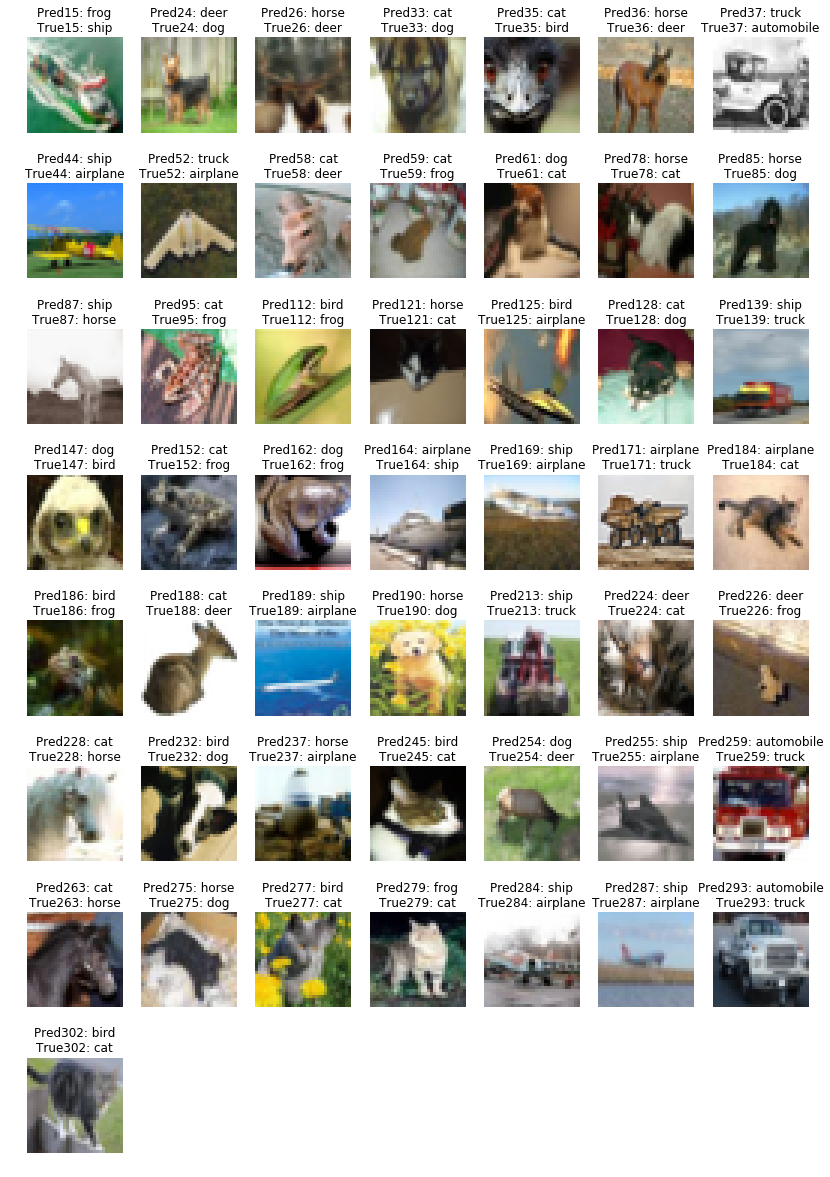

In [0]:
plt.subplots_adjust(wspace=10, hspace=10)
fig = plt.figure(figsize=(14, 21))
plot_rows = 8
plot_cols = 7
j=1
misclassified = []

for i in range(0, 303):
  predicted = np.argmax(model.predict(x_test[i:i+1]), axis=1)
  actual = np.argmax(y_test[i:i+1], axis=1)
  if predicted != actual:
    misclassified.append(i)
    
    plt.subplot(plot_rows, plot_cols, j)
    plt.axis('off')
    plt.gca().set_title("Pred" + str(i) + ": " + classes[predicted[0]] + "\nTrue" + str(i) + ": " + classes[actual[0]])
    plt.imshow(images[i])
    j += 1
#   else:
#     plt.gca().set_title('Right: ' + classes[predicted[0]] + "\nTrue: " + classes[actual[0]])

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

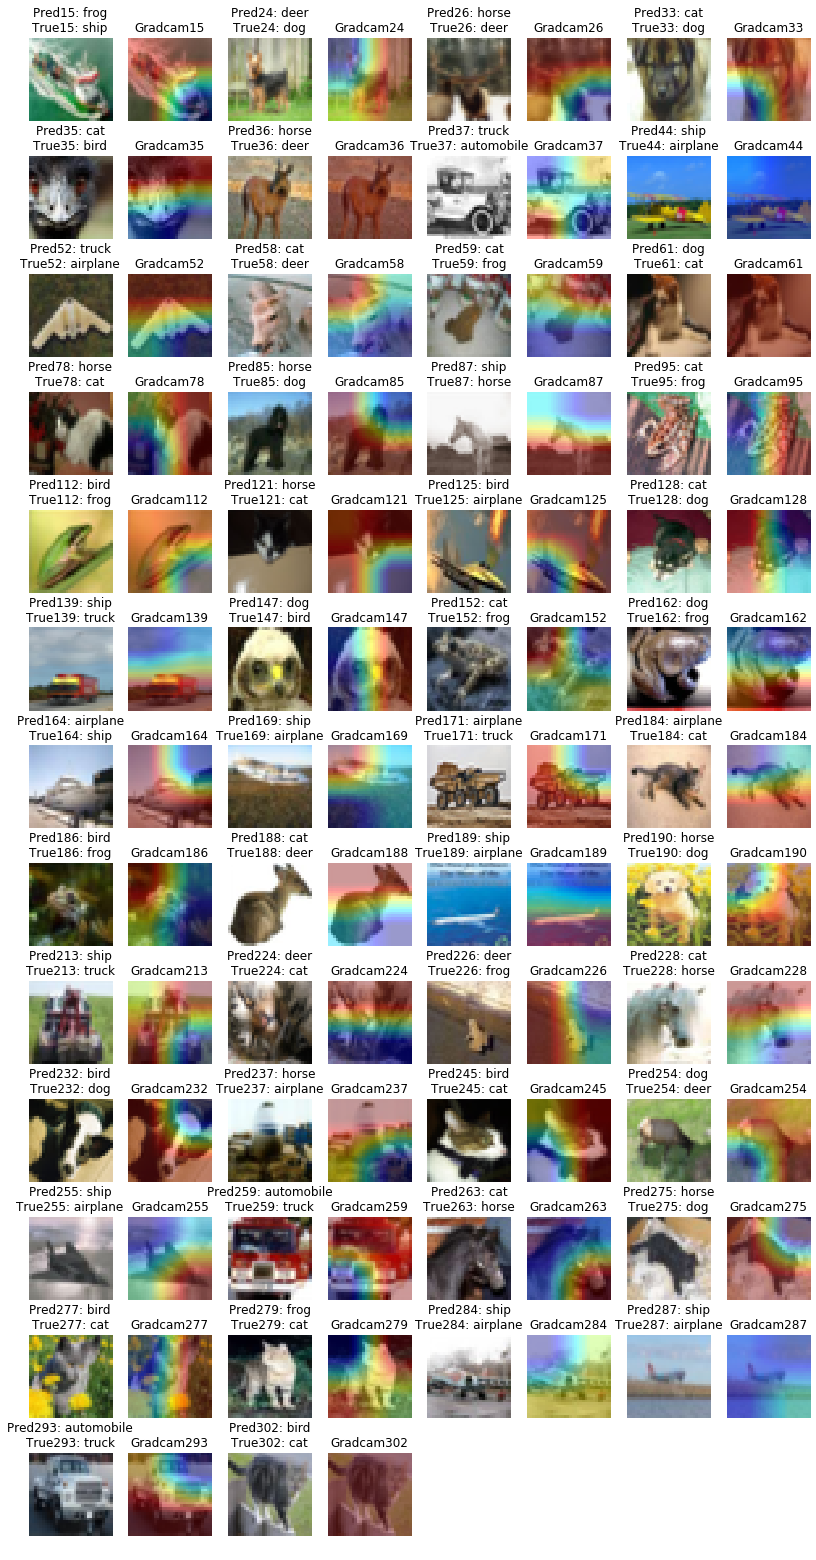

In [0]:
import cv2
from google.colab.patches import cv2_imshow

plt.subplots_adjust(wspace=10, hspace=10)
fig = plt.figure(figsize=(14, 31))
plot_rows = 14
plot_cols = 8
k=1

for i in misclassified:
  x = x_test[i:i+1]
  y = y_test[i:i+1]
  img = images[i]
  
  actual = np.argmax(y, axis=1)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]

  last_conv_layer = model.get_layer("stage3_unit1_sc")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  # range is number of channels in the selected layer
  for j in range(256):
    conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  plt.subplot(plot_rows, plot_cols, k)
  plt.axis('off')
  plt.gca().set_title("Pred" + str(i) + ": " + classes[class_idx] + "\nTrue" + str(i) + ": " + classes[actual[0]])
  plt.imshow(img)
  k += 1
  
  plt.subplot(plot_rows, plot_cols, k)
  plt.axis('off')
  plt.gca().set_title("Gradcam" + str(i))
  plt.imshow(superimposed_img)
  k += 1

plt.show()